### Articial Dataset exerimentation - simple dictionary lookup (where static fails but dynamic succeeds)

This notebook experiments with an artificial datasets designed by us

We run GAT, GATv2, and the GATDynamicBias models on it and comprare their expressive power.

The goal of this dataset is to compare the expressive power of the 3 attention layers - GAT, GATv2, and GATDynamicBias. It illustrates two points:

- The GATDynamicBias is performing a powerful kind of attention that is more expressive than that of GAT
- Without the availability of an arbitrarily large-dimensional latent representation, GATv2 could actually be worse than GAT

### Prepare Relevant imports

In [16]:
import torch.optim as optim 
import torch.nn as nn
import torch_geometric as tg
import torch

import sys
import os

import matplotlib.pyplot as plt

gat_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(gat_path)
from gat import Layer_Attention_Dynamic_GATWithBias, Layer_Attention_MultiHead_GAT, Layer_Attention_MultiHead_GATv2

import theoretical as thr

### Routines

In [2]:
def test(model,
         dataloader,
         len_all):
    model.eval()
    with torch.no_grad():
        correct = 0
        for graph in dataloader:
            nodes = graph.x
            y = graph.y
            edge_index = graph.edge_index
            adjacency = tg.utils.to_dense_adj(graph.edge_index, max_num_nodes=nodes.shape[0]).squeeze(dim=0)
            
            output = model(nodes, adjacency)
            predicted = output.argmax(dim=1)
            correct += (predicted == y).sum().item()
        accuracy = correct / (2*k*len_all)
        return accuracy
    

def train(model,
          optimiser,
          criterion, 
          dataloader,
          epoch,
          max_accuracy_before,
          len_all,
          print_frequency=10):
    model.train()
    for graph_batch in dataloader:
        nodes = graph_batch.x
        y = graph_batch.y
        edge_index = graph_batch.edge_index
        adjacency = tg.utils.to_dense_adj(edge_index, max_num_nodes=nodes.shape[0]).squeeze(dim=0)
    
        output = model(nodes, adjacency)
        loss = criterion(output, y)
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    current_accuracy = test(model=model,
                            dataloader=dataloader,
                            len_all=len_all)
    
    max_accuracy_after = max(max_accuracy_before, current_accuracy)

    if (epoch+1) % print_frequency == 0:
        print('--- \n')
        print(f'Achieved training accuracy {current_accuracy} on epoch {epoch+1}')
    
    return max_accuracy_after

### Hyperparameters

In [3]:
lr = 0.005
ks = [3, 4, 5, 6, 7, 8]
print_frequence = 10
epochs = 100
print_frequency = 20

# we set the batch_size to 1 because GATDynamicBias
# needs to know the number of nodes in advance 
# and so we want to experiment uniformly accross all
# architectures
batch_size = 1

### Running for each model

##### GAT

In [4]:
max_accuracy_list_gat = []
for k in ks:
    print(f'\n --- \n Starting training for k={k}')
    _set, _ = thr.kn_artificial(k=k, train_test_split=1.0)
    dataloader = tg.loader.DataLoader(_set, batch_size=batch_size)
    len_all = len(_set)
    
    max_accuracy_gat = 0.0
    gat_layer = Layer_Attention_MultiHead_GAT(input_dim=2*k, repr_dim=k, n_heads=1, dropout=None)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(gat_layer.parameters(), lr=lr)

    for epoch in range(epochs):
        max_accuracy_gat = train(model=gat_layer,
                                 optimiser=optimiser,
                                 criterion=criterion,
                                 dataloader=dataloader,
                                 epoch=epoch,
                                 max_accuracy_before=max_accuracy_gat,
                                 len_all=len_all,
                                 print_frequency=10)
    print(f"Training for k={k} finished, maximum accuracy achieved is {max_accuracy_gat}")
    max_accuracy_list_gat.append(max_accuracy_gat)


 --- 
 Starting training for k=3
--- 

Achieved training accuracy 0.3333333333333333 on epoch 10
--- 

Achieved training accuracy 0.5 on epoch 20
--- 

Achieved training accuracy 0.5555555555555556 on epoch 30
--- 

Achieved training accuracy 0.5 on epoch 40
--- 

Achieved training accuracy 0.4444444444444444 on epoch 50
--- 

Achieved training accuracy 0.5555555555555556 on epoch 60
--- 

Achieved training accuracy 0.5555555555555556 on epoch 70
--- 

Achieved training accuracy 0.5 on epoch 80
--- 

Achieved training accuracy 0.4444444444444444 on epoch 90
--- 

Achieved training accuracy 0.5 on epoch 100
Training for k=3 finished, maximum accuracy achieved is 0.5555555555555556

 --- 
 Starting training for k=4
--- 

Achieved training accuracy 0.3645833333333333 on epoch 10
--- 

Achieved training accuracy 0.375 on epoch 20
--- 

Achieved training accuracy 0.375 on epoch 30
--- 

Achieved training accuracy 0.3854166666666667 on epoch 40
--- 

Achieved training accuracy 0.38541666666

##### GATv2

In [6]:
max_accuracy_list_gatv2 = []
for k in ks:
    print(f'\n --- \n Starting training for k={k}')
    _set, _ = thr.kn_artificial(k=k, train_test_split=1.0)
    dataloader = tg.loader.DataLoader(_set, batch_size=batch_size)
    len_all = len(_set)
    
    max_accuracy_gatv2 = 0.0
    gat_layer = Layer_Attention_MultiHead_GATv2(input_dim=2*k, repr_dim=k, n_heads=1, dropout=None)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(gat_layer.parameters(), lr=lr)

    for epoch in range(epochs):
        max_accuracy_gatv2 = train(model=gat_layer,
                                   optimiser=optimiser,
                                   criterion=criterion,
                                   dataloader=dataloader,
                                   epoch=epoch,
                                   max_accuracy_before=max_accuracy_gatv2,
                                   len_all=len_all,
                                   print_frequency=print_frequency)
    print(f"Training for k={k} finished, maximum accuracy achieved is {max_accuracy_gatv2}")
    max_accuracy_list_gatv2.append(max_accuracy_gatv2)


 --- 
 Starting training for k=3
--- 

Achieved training accuracy 0.3333333333333333 on epoch 20
--- 

Achieved training accuracy 0.3333333333333333 on epoch 40
--- 

Achieved training accuracy 0.3333333333333333 on epoch 60
--- 

Achieved training accuracy 0.3333333333333333 on epoch 80
--- 

Achieved training accuracy 0.3333333333333333 on epoch 100
Training for k=3 finished, maximum accuracy achieved is 0.3333333333333333

 --- 
 Starting training for k=4
--- 

Achieved training accuracy 0.25 on epoch 20
--- 

Achieved training accuracy 0.25 on epoch 40
--- 

Achieved training accuracy 0.25 on epoch 60
--- 

Achieved training accuracy 0.25 on epoch 80
--- 

Achieved training accuracy 0.25 on epoch 100
Training for k=4 finished, maximum accuracy achieved is 0.25

 --- 
 Starting training for k=5
--- 

Achieved training accuracy 0.2 on epoch 20
--- 

Achieved training accuracy 0.2 on epoch 40
--- 

Achieved training accuracy 0.2 on epoch 60
--- 

Achieved training accuracy 0.2 on epo

##### GATDynamicBias

In [10]:
max_accuracy_list_gatdb = []
for k in ks:
    if k == 7:
        # otherwise too slow, and the results are pretty good even with 20 epochs
        epochs = 20
    print(f'\n --- \n Starting training for k={k}')
    _set, _ = thr.kn_artificial(k=k, train_test_split=1.0)
    dataloader = tg.loader.DataLoader(_set, batch_size=batch_size)
    len_all = len(_set)
    
    max_accuracy_gatdb = 0.0
    gat_layer = Layer_Attention_Dynamic_GATWithBias(input_dim=2*k, repr_dim=k, n_heads=1, n_nodes=2*k, epsilon_bias=1.0, dropout=None)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(gat_layer.parameters(), lr=lr)

    for epoch in range(epochs):
        max_accuracy_gatdb = train(model=gat_layer,
                                   optimiser=optimiser,
                                   criterion=criterion,
                                   dataloader=dataloader,
                                   epoch=epoch,
                                   max_accuracy_before=max_accuracy_gatdb,
                                   len_all=len_all,
                                   print_frequency=print_frequency)
    print(f"Training for k={k} finished, maximum accuracy achieved is {max_accuracy_gatdb}")
    max_accuracy_list_gatdb.append(max_accuracy_gatdb)


 --- 
 Starting training for k=3
--- 

Achieved training accuracy 0.4722222222222222 on epoch 20
--- 

Achieved training accuracy 0.5833333333333334 on epoch 40
--- 

Achieved training accuracy 0.8055555555555556 on epoch 60
--- 

Achieved training accuracy 1.0 on epoch 80
--- 

Achieved training accuracy 1.0 on epoch 100
Training for k=3 finished, maximum accuracy achieved is 1.0

 --- 
 Starting training for k=4
--- 

Achieved training accuracy 1.0 on epoch 20
--- 

Achieved training accuracy 1.0 on epoch 40
--- 

Achieved training accuracy 1.0 on epoch 60
--- 

Achieved training accuracy 1.0 on epoch 80
--- 

Achieved training accuracy 1.0 on epoch 100
Training for k=4 finished, maximum accuracy achieved is 1.0

 --- 
 Starting training for k=5
--- 

Achieved training accuracy 1.0 on epoch 20
--- 

Achieved training accuracy 1.0 on epoch 40
--- 

Achieved training accuracy 1.0 on epoch 60
--- 

Achieved training accuracy 1.0 on epoch 80
--- 

Achieved training accuracy 1.0 on epoch

### Plotting

In [12]:
max_accuracy_list_gat

[0.5555555555555556,
 0.4739583333333333,
 0.36,
 0.3353009259259259,
 0.35714285714285715,
 0.3507719494047619]

In [15]:
max_accuracy_list_gatv2

[0.3333333333333333,
 0.25,
 0.2,
 0.16666666666666666,
 0.14287131519274376,
 0.12500465029761904]

In [17]:
max_accuracy_list_gatdb

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

/var/folders/nm/d_yk3tzj221cbr7pqlbvgd080000gn/T/ipykernel_82711/1515963934.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


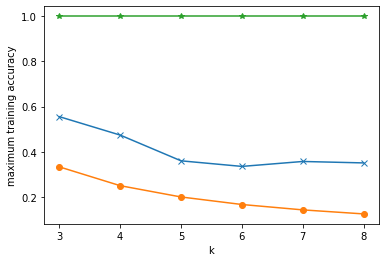

In [32]:
fig = plt.figure()

plt.plot(ks, max_accuracy_list_gat, label="GAT", marker='x')
plt.plot(ks, max_accuracy_list_gatv2, label="GATv2", marker='o')
plt.plot(ks, max_accuracy_list_gatdb, label="GATDynamicBias", marker='*')

plt.xlabel('k')
plt.ylabel('maximum training accuracy')

fig.show()
fig.savefig('artificial_dataset_demo.png');